Below takes pcr swap probabilities and gapfill error probabilities for predefined feature set and returns cell genotypes with probabilities.
This should be pretty generic but may need adjustment if there are multiple possible alleles for the same probe

In [1]:
import sys
from gapfill_utilities import utils as gf_utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
# sys.path.append('/home/blattms1/projects/gapfill/4CL_JAK2/likelihood_model/src/')
# import utils as lm_utils
import scanpy as sc
import os


In [2]:
feature_set = 'feature_set_all.csv'

for lib in ['1plex','1','2','4plex']:
    os.system('mkdir likelihood_tables_with_null_' + lib)
    if lib == '4plex':
        BCs = ['BC001', 'BC002', 'BC003', 'BC004']
    elif lib == '1plex':
        BCs = ['BC001']
    else:
        BCs = ['BC001', 'BC002', 'BC003', 'BC004', 'BC005', 'BC006', 'BC007', 'BC008', 'BC009', 'BC010', 'BC011', 'BC012', 'BC013', 'BC014', 'BC015', 'BC016']

    for BC in BCs:
        sample = BC + '_' + lib
        alt_gapfill_set = pd.read_csv(feature_set)
        gf_dirs = {}
        ### first get probe_reads to use for the patient
        if lib == '4plex':
            adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20250318_rerun_JAK2_patients_' + BC + '.h5ad'
            gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_4plex_1/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
            gf_dirs[1] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_4plex_2/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
        elif lib == '1plex':
            adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20241114_rerun_JAK2_patients_' + BC + '.h5ad'
            gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_20241114/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
        else:
            adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20250605_MPN_' + lib + '_' + BC + '.h5ad'
            gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_1/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
            gf_dirs[1] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_2/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'

        null_set = pd.DataFrame()
        sample = BC + '_' + lib
        temp = alt_gapfill_set[alt_gapfill_set['sample'] != sample][['name','HGVSc','gapfill','gapfill_from_transcriptome','original_name']].drop_duplicates()
        temp['sample'] = sample
        null_set = pd.concat([null_set, temp])
        try:
            gapfill_likelihoods = pd.read_csv('likelihood_tables_' + lib + '/' + BC + '_gapfill_likelihoods.csv')
        except FileNotFoundError:
            gapfill_likelihoods = pd.DataFrame()
            gapfill_likelihoods['probe_idx'] = pd.Series(dtype=int)
            
        manifest = gf_utils.get_manifest(gf_dirs[0])
        probe_name_to_probe_idx = dict(zip(manifest['name'], manifest['index']))
        null_set['probe_idx'] = null_set['original_name'].map(probe_name_to_probe_idx)

        null_set = null_set.loc[~null_set['probe_idx'].isin(gapfill_likelihoods['probe_idx'])]
        null_set = null_set.dropna(subset='probe_idx')

        null_set_likelihoods = pd.get_dummies(null_set.set_index('probe_idx')['gapfill_from_transcriptome']).astype(int) ### diagonalize so only wt gapfill is allowed for null set

        alt_gapfill_set = alt_gapfill_set[alt_gapfill_set['sample'] == sample]
        alt_gapfill_set = pd.concat([alt_gapfill_set, null_set], ignore_index=True)
        gapfill_likelihoods = pd.concat([gapfill_likelihoods, null_set_likelihoods.reset_index()], ignore_index=True)

        alt_gapfill_set['probe_idx'] = alt_gapfill_set['original_name'].map(probe_name_to_probe_idx)
        alt_gapfill_set.to_csv('likelihood_tables_with_null_' + lib + '/' + BC + '_feature_set.csv', index=False)
        gapfill_likelihoods.to_csv('likelihood_tables_with_null_' + lib + '/' + BC + '_gapfill_likelihoods.csv', index=False)

mkdir: cannot create directory ‘likelihood_tables_with_null_1plex’: File exists
mkdir: cannot create directory ‘likelihood_tables_with_null_1’: File exists
mkdir: cannot create directory ‘likelihood_tables_with_null_2’: File exists
mkdir: cannot create directory ‘likelihood_tables_with_null_4plex’: File exists


In [3]:
## these are now in lm_utils but there is an error and it's not updated
def get_p(allele1,allele2,fracs_1,sub_probe_reads):
    prob_columns = []
    for frac_1 in fracs_1:
        frac_2 = 1 - frac_1
        sub_probe_reads[allele1] = sub_probe_reads['p_' + allele1] * frac_1
        sub_probe_reads[allele2] = sub_probe_reads['p_' + allele2] * frac_2
        col_name = 'p_' + allele1 + '_' + allele2 + '_' + str(frac_1) + '_' + str(frac_2)
        if frac_1 == 0 and frac_2 == 1:
            col_name = 'p_' + allele2 + '_1'
        elif frac_1 == 1 and frac_2 == 0:
            col_name = 'p_' + allele1 + '_1'
        sub_probe_reads[col_name] = sub_probe_reads[['pcr_swap_likelihood', allele1, allele2]].max(axis=1)
        prob_columns.append(col_name)
        allele_call_col = col_name.replace('p_','') + '_n_allele_1'
        sub_probe_reads[allele_call_col] = sub_probe_reads[['pcr_swap_likelihood', allele1, allele2]].idxmax(axis=1)
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == 'pcr_swap_likelihood',allele_call_col] = None
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == allele2,allele_call_col] = 0
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == allele1,allele_call_col] = 1
        sub_probe_reads.drop(columns=[allele1, allele2], inplace=True)
    return sub_probe_reads, prob_columns

def update_het_frac(sub_probe_reads, prob_columns):
    cell_genotypes = sub_probe_reads.groupby(['cell_idx', 'barcode'])[prob_columns].prod()
    cell_genotypes = cell_genotypes.div(cell_genotypes.sum(axis=1), axis=0)
    het_cols = cell_genotypes.columns[~(cell_genotypes.columns.str.contains('0_1') | cell_genotypes.columns.str.contains('1_0'))]
    het_cells = cell_genotypes.loc[cell_genotypes[het_cols].sum(axis=1) > 0.8].index.get_level_values('barcode').unique()
    if len(het_cells) > 20:
        cols = sub_probe_reads.columns[(sub_probe_reads.columns.str.contains('n_allele_1')) & ~(sub_probe_reads.columns.str.contains('0_1')) & ~(sub_probe_reads.columns.str.contains('1_0'))]
        updated_frac1 = sub_probe_reads.loc[sub_probe_reads['barcode'].isin(het_cells)].groupby(['cell_idx','barcode'])[cols].mean().mean().mean()
        return updated_frac1
    else:
        return 0.5

def rename_genotype_columns(cell_genotypes, genotype_names):
    temp = cell_genotypes[['cell_idx','barcode']].copy()
    # if len(genotype_names.loc[genotype_names['variant'] == True]) == 0:

    for variant,name in genotype_names.loc[genotype_names['variant'] == True][['gapfill_value','name']].values:
        wt_gapfill = genotype_names.loc[(genotype_names['name'] == name) & (genotype_names['variant'] == False)]['gapfill_value'].values[0]
        if 'p_' + variant + '_1' in cell_genotypes.columns:
            temp[name + '_mutated'] = cell_genotypes['p_' + variant + '_1']
        if 'p_' + wt_gapfill + '_1' in cell_genotypes.columns:
            temp[name + '_wt'] = cell_genotypes['p_' + wt_gapfill + '_1']
        if 'p_' + variant + '_' + wt_gapfill + '_0.5_0.5' in cell_genotypes.columns:
            temp[name + '_heterozygous'] = cell_genotypes['p_' + variant + '_' + wt_gapfill + '_0.5_0.5']
        elif 'p_' + wt_gapfill + '_' + variant + '_0.5_0.5' in cell_genotypes.columns:
            temp[name + '_heterozygous'] = cell_genotypes['p_' + wt_gapfill + '_' + variant + '_0.5_0.5']
    
    if len(genotype_names.loc[genotype_names['variant'] == True]['gapfill_value'].values) > 1:
        all_variants, names = genotype_names.loc[genotype_names['variant'] == True][['gapfill_value','name']].values.T
        variant_to_name = dict(zip(all_variants, names))
        for variant_combination in list(combinations(np.sort(all_variants), 2)):
            variant1 = variant_combination[0]
            variant2 = variant_combination[1]
            if 'p_' + variant1 + '_' + variant2 + '_0.5_0.5' in cell_genotypes.columns:
                temp[variant_to_name[variant1] + '_' + variant_to_name[variant2] + '_heterozygous'] = cell_genotypes['p_' + variant1 + '_' + variant2 + '_0.5_0.5']
            elif 'p_' + variant2 + '_' + variant1 + '_0.5_0.5' in cell_genotypes.columns:
                temp[variant_to_name[variant1] + '_' + variant_to_name[variant2] + '_heterozygous'] = cell_genotypes['p_' + variant2 + '_' + variant1 + '_0.5_0.5']
    return temp

def get_cell_genotypes(probe_idx,probe_reads,genotype_names,fracs_1 = [0,0.5,1], learn_het_frac = True):
    sub_probe_reads = probe_reads.loc[probe_reads['probe_idx'] == probe_idx]
    sub_probe_reads = sub_probe_reads.dropna(axis=1, how='all')
    possible_alleles = sub_probe_reads.columns[sub_probe_reads.columns.str.contains('p_gapfill_given_')]
    sub_probe_reads[possible_alleles.str.replace('_gapfill_given','')] = sub_probe_reads[possible_alleles].div(sub_probe_reads[possible_alleles].sum(axis=1), axis=0)
    sub_probe_reads = sub_probe_reads.drop(columns=possible_alleles)
    possible_alleles = possible_alleles.str.replace('p_gapfill_given_','')
    all_prob_columns = []

    if len(possible_alleles) == 1:
        allele1 = possible_alleles[0]
        sub_probe_reads, prob_columns = get_p(allele1, allele1, [0], sub_probe_reads)
        all_prob_columns.extend(prob_columns)

    else:
        for allele_combination in list(combinations(possible_alleles, 2)):
            allele1 = allele_combination[0]
            allele2 = allele_combination[1]
            sub_probe_reads, prob_columns = get_p(allele1, allele2, fracs_1, sub_probe_reads)
            all_prob_columns.extend(prob_columns)
            if learn_het_frac:
                updated_het_frac = np.round(update_het_frac(sub_probe_reads, prob_columns),2)
                sub_probe_reads, prob_columns = get_p(allele1, allele2, [0,updated_het_frac,1], sub_probe_reads)
                all_prob_columns.extend(prob_columns)
    all_prob_columns = list(set(all_prob_columns))
    cell_genotypes = sub_probe_reads.groupby(['cell_idx', 'barcode'])[all_prob_columns].prod()
    cell_genotypes = cell_genotypes.div(cell_genotypes.sum(axis=1), axis=0)
    cell_genotypes = cell_genotypes.reset_index()
    cell_genotypes = rename_genotype_columns(cell_genotypes, genotype_names)
    for probe_name in cell_genotypes.columns[cell_genotypes.columns.str.contains('_wt')].str.replace('_wt',''):
        cell_genotypes[probe_name + '_high_confidence_counts'] = cell_genotypes['barcode'].map(sub_probe_reads.loc[sub_probe_reads['pcr_swap_likelihood'] < 0.1]['barcode'].value_counts().to_dict()).fillna(0)
    return cell_genotypes


1419549 UMIs found
Collapsing UMIs across probes, 1419549 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1414497 UMIs remaining (99.64%)
Filtering cells based on min counts (0) and genes (0) in WTA
Filtering probe reads based on cell barcodes in adata, 1336431 UMIs remaining (94.14%)
1645255 UMIs found
Collapsing UMIs across probes, 1645255 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1639748 UMIs remaining (99.67%)
Filtering cells based on min counts (0) and genes (0) in WTA
Filtering probe reads based on cell barcodes in adata, 1540837 UMIs remaining (93.65%)


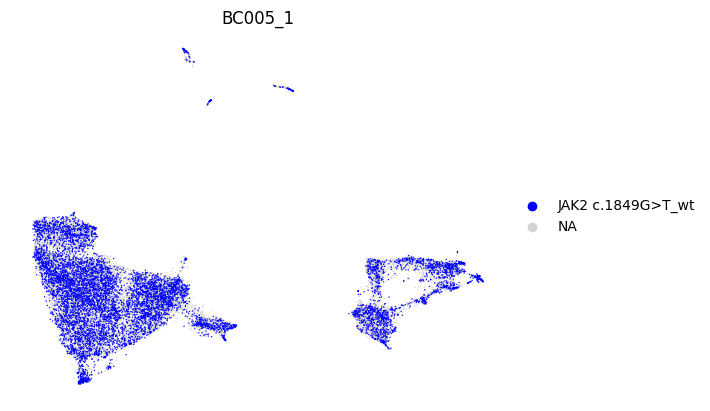

In [4]:
# for lib in ['1plex','1','2','4plex']:
#     if lib == '4plex':
#         BCs = ['BC001', 'BC002', 'BC003', 'BC004']
#     elif lib == '1plex':
#         BCs = ['BC001']
#     else:
#         BCs = ['BC001', 'BC002', 'BC003', 'BC004', 'BC005', 'BC006', 'BC007', 'BC008', 'BC009', 'BC010', 'BC011', 'BC012', 'BC013', 'BC014', 'BC015', 'BC016']

for lib in ['1']:
    BCs = ['BC005']

    for BC in BCs:
        sample = BC + '_' + lib

        gf_dirs = {}
        ### first get probe_reads to use for the patient
        if lib == '4plex':
            adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20250318_rerun_JAK2_patients_' + BC + '.h5ad'
            gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_4plex_1/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
            gf_dirs[1] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_4plex_2/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
        elif lib == '1plex':
            adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20241114_rerun_JAK2_patients_' + BC + '.h5ad'
            gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_20241114/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
        else:
            adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20250605_MPN_' + lib + '_' + BC + '.h5ad'
            gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_1/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
            gf_dirs[1] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_2/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'

        min_percent_supporting = 0.9
        collapse_across_probes = True
        for key,gf_dir in gf_dirs.items():
            if key == 0:
                probe_reads = gf_utils.get_input_probe_reads(gf_dir, read_threshold = 0, cell_barcode_suffix = '-' + str(key), adata_path = adata_path, min_percent_supporting=min_percent_supporting, collapse_across_probes=collapse_across_probes)
            else:
                probe_reads = pd.concat([probe_reads, gf_utils.get_input_probe_reads(gf_dir, read_threshold = 0, cell_barcode_suffix = '-' + str(key), adata_path = adata_path, min_percent_supporting=min_percent_supporting, collapse_across_probes=collapse_across_probes)], ignore_index=True)

        gapfill_likelihoods = pd.read_csv('likelihood_tables_with_null_' + lib + '/' + BC + '_gapfill_likelihoods.csv')
        columns_to_rename = gapfill_likelihoods.columns.difference(['probe_idx', 'gapfill'])
        gapfill_likelihoods.rename(columns={col: 'p_gapfill_given_' + col for col in columns_to_rename}, inplace=True)

        pcr_swap_likelihoods = pd.read_csv('likelihood_tables_' + lib + '/patient_' + BC + '_swap_probabilities.csv')
        pcr_swap_likelihoods.rename(columns={'likelihood':'no_pcr_swap_likelihood'}, inplace=True)
        pcr_swap_likelihoods['pcr_swap_likelihood'] = 1 - pcr_swap_likelihoods['no_pcr_swap_likelihood']

        if 'gapfill' not in gapfill_likelihoods.columns:
            gapfill_likelihoods['gapfill'] = np.nan

        variant_probes = gapfill_likelihoods.loc[gapfill_likelihoods['gapfill'].notna(),'probe_idx'].unique()
        if len(variant_probes) > 0:
            probe_reads1 = probe_reads.loc[probe_reads['probe_idx'].isin(variant_probes)]
            probe_reads1 = probe_reads1.merge(gapfill_likelihoods.loc[gapfill_likelihoods['gapfill'].notna()], how='left', on = ['probe_idx','gapfill'])

        nonvariant_probes = gapfill_likelihoods.loc[~(gapfill_likelihoods['probe_idx'].isin(variant_probes)) & (gapfill_likelihoods['gapfill'].isna()),'probe_idx'].unique()
        probe_reads2 = probe_reads.loc[probe_reads['probe_idx'].isin(nonvariant_probes)]
        probe_reads2 = probe_reads2.merge(gapfill_likelihoods.loc[gapfill_likelihoods['gapfill'].isna()].drop('gapfill',axis=1), how='left', on = ['probe_idx'])

        if len(variant_probes) == 0:
            probe_reads = probe_reads2.copy()
        else:
            probe_reads = pd.concat([probe_reads1, probe_reads2], ignore_index=True).reset_index(drop=True)
        probe_reads = probe_reads.merge(pcr_swap_likelihoods[['pcr_duplicate_count','pcr_swap_likelihood']], how='left', on = 'pcr_duplicate_count')
        probe_reads.drop(['umi','percent_supporting','probe_barcode'],axis=1, inplace=True)

        alt_genotypes = pd.read_csv('likelihood_tables_with_null_' + lib + '/' + BC + '_feature_set.csv')
        alt_genotypes = alt_genotypes.loc[alt_genotypes['sample'] == sample].dropna(subset='HGVSc')
        alt_genotypes['gapfill'] = alt_genotypes['gapfill'].fillna('')
        alt_genotypes['name'] = alt_genotypes['HGVSc'].copy()

        alt_genotypes = pd.concat([
            alt_genotypes[['probe_idx', 'name', 'gapfill']].rename(columns={'gapfill': 'gapfill_value'}).assign(variant=True),
            alt_genotypes[['probe_idx', 'name', 'gapfill_from_transcriptome']].rename(columns={'gapfill_from_transcriptome': 'gapfill_value'}).assign(variant=False)
        ], ignore_index=True)

        alt_genotypes['gapfill_value'] = alt_genotypes['gapfill_value'].fillna('')

        cell_genotypes = {}
        for probe_idx in probe_reads['probe_idx'].unique():
            pr = probe_reads.loc[probe_reads['probe_idx'] == probe_idx].dropna(axis=1, how='all')
            pr = pr.loc[:,((pr != 0).sum() > 0) | ~(pr.columns.str.contains('p_'))]
            cell_genotypes[probe_idx] = get_cell_genotypes(probe_idx,pr, alt_genotypes.loc[alt_genotypes['probe_idx'] == probe_idx], learn_het_frac = False)

        all_df = pd.DataFrame()
        for probe_idx in cell_genotypes.keys():
            df = cell_genotypes[probe_idx].set_index('barcode').drop(['cell_idx'],axis=1)
            all_df = all_df.merge(df, how='outer', left_index=True, right_index=True)

        adata = gf_utils.read_adata(adata_path)
        adata.obsm['genotypes'] = all_df.reindex(adata.obs_names)

        if 'JAK2 c.1849G>T_mutated' in adata.obsm['genotypes'].columns:
            adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)
        else:
            adata.obs['genotype'] = adata.obsm['genotypes']['JAK2 c.1849G>T_wt'].map({1: 'JAK2 c.1849G>T_wt'})
        sc.pl.umap(adata, color='genotype', frameon=False, palette={'JAK2 c.1849G>T_mutated':'red','JAK2 c.1849G>T_wt':'blue','JAK2 c.1849G>T_heterozygous':'orange'}, title = sample)
        # adata.write(adata_path.replace('.h5ad','_genotyped_v2.h5ad'))



In [ ]:
# adata.write(adata_path.replace('.h5ad','_genotyped_v2_temp.h5ad'))
# adata.write(adata_path.replace('.h5ad','_genotyped_v2.h5ad'))
